In [1]:
# import math
import numpy as np
import pandas as pd
import scipy.stats as st
import sys
# import itertools
# from functions import *
from mining_functions import *
# from collections import Counter
import matplotlib.pyplot as plt
from tabulate import tabulate
from scipy import stats
# from matplotlib.backends.backend_pdf import PdfPages
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = 25, 15

## Importing data

In [2]:
PATH = '/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
def get_path(path = PATH):
    if os.name == 'posix':
        path = '/Documents/code/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['HOME']+path #'/Google Drive/Jonathan Sarah Ido folder/data/CCK/'
    elif os.name == 'nt':
        if os.getenv("COMPUTERNAME") == 'PYRRHA':
                path = '/Documents/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        else:
            path = '/git/Phet-log-analyzer/cck/raw_data_parsing_check/'
        return os.environ['USERPROFILE']+ path.replace('/','\\') #'\\Google Drive\Jonathan Sarah Ido folder\data\CCK\\'
    else:
        raise Exception('OS not recongnized. I\'m confused.')
        
df = pd.read_csv(get_path() + 'phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
# dfx = pd.read_csv('C:\Users\Sarah\Documents\git\Phet-log-analyzer\cck\\raw_data_parsing_check\phet_cck_user_actions+sophistication_WITHPAUSE_more_circuit_info.txt',index_col=False)
df["student"] = df["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()
df["Family_tool"]=df["Family_tool"].str.capitalize()
df["Family_default"]=df["Family_default"].str.capitalize()
df["Family_both"]=df["Family_both"].str.capitalize()

df_scores = pd.read_csv(data_path + 'MATCHING_phet_cck_user_data_anonymized.txt')
df_scores["student"] = df_scores["student"].astype('category')

#### Crop activity data to get rid of activity #3

In [3]:
max_time = 25*60*1000
max_times = {s:min(df[df['student']==s]["Time Stamp"])+max_time for s in set(df['student'])}

def keep_by_time (row):
    if row["Time Stamp"] <= max_times[row["student"]]:
        return True
    else: 
        return False

df['keep'] = df.apply (lambda row: keep_by_time (row),axis=1)
df=df[df['keep']]

## Define LH and LL groups

There are a total of 74 novices of which LL=36 and LH=38
There are a total of 22 incoming experts of which HH=19 and HL=3


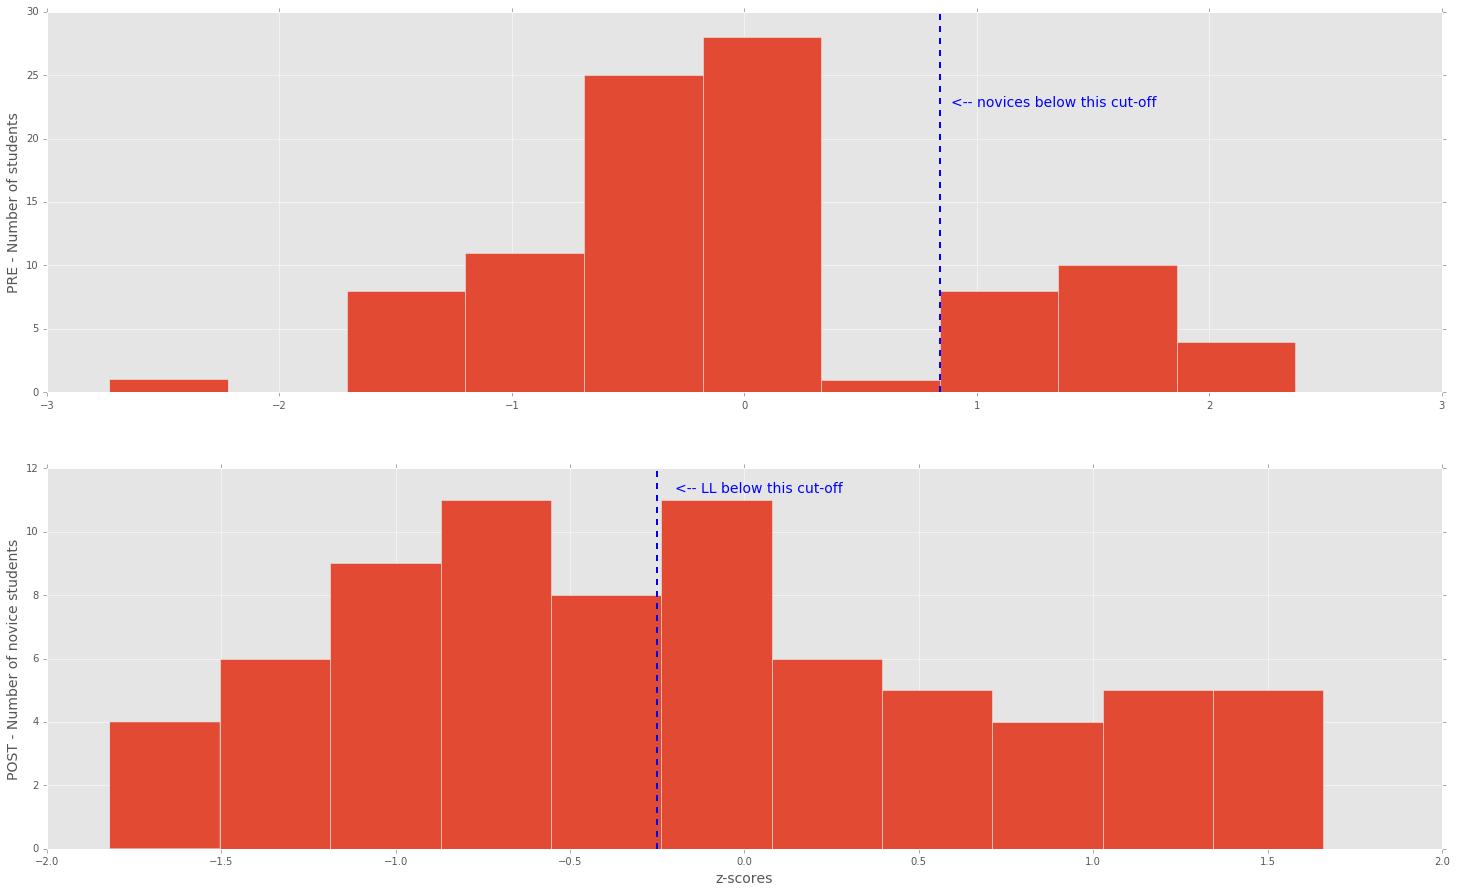

In [4]:
##plot pre-test z-scores
pre_scores = df_scores['z pre']
plt.subplot(2,1,1)
hpre = plt.hist(pre_scores)
plt.ylabel('PRE - Number of students', fontsize=14)
#cut-off for novices defined at minima in bimodal dist
cutoff = hpre[1][7]
plt.axvline(cutoff, ls = '--', lw = 2)
plt.text(cutoff+0.05, 22.5, '<-- novices below this cut-off', fontsize=14, color='blue')

##plot post-test z-scores of novices (as defined above)
post_scores_novices = df_scores['z post t2'][df_scores['z pre'] < cutoff]
plt.subplot(2,1,2)
hpost = plt.hist(post_scores_novices, bins=11)
plt.ylabel('POST - Number of novice students', fontsize=14)
plt.xlabel('z-scores', fontsize=14)
#cut-off for high vs low learning novice defined by median split
post_scores_novices_mdn = np.median(post_scores_novices)
plt.axvline(post_scores_novices_mdn, ls = '--', lw = 2)
plt.text(post_scores_novices_mdn+0.05, 11.25, '<-- LL below this cut-off', fontsize=14, color='blue')

##forming groups of students ID for LL, LH, HH and HL
students = df_scores['student']
novice_students = df_scores['student'][df_scores['z pre'] < cutoff]
low_post_students = df_scores['student'][df_scores['z post t2'] < post_scores_novices_mdn]
high_post_students = df_scores['student'][df_scores['z post t2'] >= post_scores_novices_mdn]
LL_students = list( set(novice_students) & set(low_post_students) )
LH_students = list( set(novice_students) - set(LL_students) )
HH_students = list( set(students) & set(high_post_students) - set(novice_students) )
HL_students = list( set(students) & set(low_post_students) - set(novice_students) )
print 'There are a total of {} novices of which LL={} and LH={}'.format(len(novice_students),len(LL_students), len(LH_students))
print 'There are a total of {} incoming experts of which HH={} and HL={}'.format(len(students)-len(novice_students),len(HH_students), len(HL_students))


## Identifying who uses top ranked sequences

In [5]:
#top 5 ranked sequences for LH student group
top5seqLH = ['PTsPC', 'CTsPTsP', 'PTsP', 'TsPTsPC', 'CPTs']
#top 5 ranked sequences for LL student group
top5seqLL = ['PCTcCTcC', 'CPCTsC', 'PCPCTcC', 'TcCPC', 'TsCTsC']

In [6]:
#get all action blocks in one long string per students for LL and LH groups.
blocksLH, _ = get_blocks_withTime_new(df, LH_students, 'Family', as_list = False, ignore = ['I'], start = False)
blocksLL, _ = get_blocks_withTime_new(df, LL_students, 'Family', as_list = False, ignore = ['I'], start = False)

### Student usage of top ranked sequences

#### LH students and top ranked LH sequences:

In [7]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked LH sequence --> unique LH students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqLH:
    a = list([ student for student in LH_students if len(re.findall(seq, blocksLH[student]))>=numtimes ])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_LH1 = set(student_list)
print "Total unique LH students using any of top 5 LH sequences:", len(unique_student_list_LH1),
print ', which is', len(unique_student_list_LH1)/(1.0*len(LH_students)), 'of the LH population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_LH1)].value_counts()

Top ranked LH sequence --> unique LH students that used it at least x1
PTsPC --> 20
CTsPTsP --> 13
PTsP --> 23
TsPTsPC --> 13
CPTs --> 15
Total unique LH students using any of top 5 LH sequences: 25 , which is 0.657894736842 of the LH population 

Number of these students in each support condition:
scaff    14
not      11
Name: scaffolding, dtype: int64


#### LH students and top ranked LL sequences:

In [8]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked LL sequence --> unique LH students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqLL:
    a = list([ student for student in LH_students if len(re.findall(seq, blocksLH[student]))>=numtimes ])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_LH2 = set(student_list)
print "Total unique LH students using any of top 5 LL sequences:", len(unique_student_list_LH2),
print ', which is', len(unique_student_list_LH2)/(1.0*len(LH_students)), 'of the LH population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_LH2)].value_counts()

Top ranked LL sequence --> unique LH students that used it at least x1
PCTcCTcC --> 5
CPCTsC --> 5
PCPCTcC --> 5
TcCPC --> 8
TsCTsC --> 6
Total unique LH students using any of top 5 LL sequences: 18 , which is 0.473684210526 of the LH population 

Number of these students in each support condition:
scaff    11
not       7
Name: scaffolding, dtype: int64


#### LL students and top ranked LL sequences:

In [9]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked LL sequence --> unique LL students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqLL:
    a = list([ student for student in LL_students if len(re.findall(seq, blocksLL[student]))>=numtimes ])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_LL1 = set(student_list)
print "Total unique LL students using any of top 5 LL sequences:", len(unique_student_list_LL1),
print ', which is', len(unique_student_list_LL1)/(1.0*len(LL_students)), 'of the LL population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_LL1)].value_counts()

Top ranked LL sequence --> unique LL students that used it at least x1
PCTcCTcC --> 13
CPCTsC --> 13
PCPCTcC --> 12
TcCPC --> 18
TsCTsC --> 13
Total unique LL students using any of top 5 LL sequences: 29 , which is 0.805555555556 of the LL population 

Number of these students in each support condition:
not      18
scaff    11
Name: scaffolding, dtype: int64


#### LL students and top ranked LH sequences:

In [10]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked LH sequence --> unique LL students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqLH:
    a = list([ student for student in LL_students if len(re.findall(seq, blocksLL[student]))>=numtimes ])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_LL2 = set(student_list)
print "Total unique LL students using any of top 5 LH sequences:", len(unique_student_list_LL2),
print ', which is', len(unique_student_list_LL2)/(1.0*len(LL_students)), 'of the LL population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_LL2)].value_counts()

Top ranked LH sequence --> unique LL students that used it at least x1
PTsPC --> 7
CTsPTsP --> 5
PTsP --> 9
TsPTsPC --> 5
CPTs --> 7
Total unique LL students using any of top 5 LH sequences: 10 , which is 0.277777777778 of the LL population 

Number of these students in each support condition:
scaff    5
not      5
Name: scaffolding, dtype: int64


### Tabulate all the above and check independence

In [11]:
#Summary of results 
colnames = ['LL students','LH students']
rownames = ['did LL top ranked seqs','did LH top ranked seqs']
t11 = 29
t12 = 18
t21 = 10
t22 = 25
to_print = [["",colnames[0],colnames[1],"total"]]
to_print.append([rownames[0],t11,t12,t11+t12])
to_print.append([rownames[1],t21,t22,t21+t22])
to_print.append(["total",t11+t21,t12+t22,t11+t12+t21+t22])
print tabulate(to_print)

# obs = np.array([[t11, t12], [t21, t22]])
# chi2, p, dof, ex = st.chi2_contingency(obs, correction=False)
# print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

----------------------  -----------  -----------  -----
                        LL students  LH students  total
did LL top ranked seqs  29           18           47
did LH top ranked seqs  10           25           35
total                   39           43           82
----------------------  -----------  -----------  -----


In [12]:
#Do contingency table for LL/LH vs doing top ranked LL/LH sequences
colnames = ['LL students','LH students']
rownames = ['did LL top ranked seqs','did not']
t11 = 29
t12 = 18
t21 = len(LL_students) - t11
t22 = len(LH_students) - t12
to_print = [["",colnames[0],colnames[1],"total"]]
to_print.append([rownames[0],t11,t12,t11+t12])
to_print.append([rownames[1],t21,t22,t21+t22])
to_print.append(["total",t11+t21,t12+t22,t11+t12+t21+t22])
print tabulate(to_print)

obs = np.array([[t11, t12], [t21, t22]])
chi2, p, dof, ex = st.chi2_contingency(obs, correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

----------------------  -----------  -----------  -----
                        LL students  LH students  total
did LL top ranked seqs  29           18           47
did not                 7            20           27
total                   36           38           74
----------------------  -----------  -----------  -----
Chi^2 = 8.78609118014, p = 0.00303535944626, dof = 1


In [13]:
#Do contingency table for LL/LH vs doing top ranked LL/LH sequences
colnames = ['LL students','LH students']
rownames = ['did LH top ranked seqs','did not']
t11 = 10
t12 = 25
t21 = len(LL_students) - t11
t22 = len(LH_students) - t12
to_print = [["",colnames[0],colnames[1],"total"]]
to_print.append([rownames[0],t11,t12,t11+t12])
to_print.append([rownames[1],t21,t22,t21+t22])
to_print.append(["total",t11+t21,t12+t22,t11+t12+t21+t22])
print tabulate(to_print)

obs = np.array([[t11, t12], [t21, t22]])
chi2, p, dof, ex = st.chi2_contingency(obs, correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

----------------------  -----------  -----------  -----
                        LL students  LH students  total
did LH top ranked seqs  10           25           35
did not                 26           13           39
total                   36           38           74
----------------------  -----------  -----------  -----
Chi^2 = 10.7156780841, p = 0.00106231519303, dof = 1


## Test of indepedence between groups and support condition

In [14]:
#Do contingency table for LL/LH vs scaff/not and test independence of observed occurences
slh = 14
nslh = 11
sll = 11
nsll = 18
to_print = [["","Low-High","Low-Low","total"]]
to_print.append(["scaff",slh,sll,sll+slh])
to_print.append(["not scaff",nslh,nsll,nsll+nslh])
to_print.append(["total",nslh+slh,nsll+sll,nsll+sll+nslh+slh])
print tabulate(to_print)

# total = float(slh + nslh + sll + nsll)
# print stats.chisquare(f_obs= [slh,sll],   # Array of observed counts
#                 f_exp= [(slh+nslh)*(slh+sll)/total,(sll+nsll)*(slh+sll)/total])   # Array of expected counts
# print stats.chisquare(f_obs= [nslh,nsll],   # Array of observed counts
#                 f_exp= [(slh+nslh)*(nslh+nsll)/total,(sll+nsll)*(nslh+nsll)/total])   # Array of expected counts

obs = np.array([[slh, nslh], [sll, nsll]])
chi2, p, dof, ex = st.chi2_contingency(obs, correction=False)
print 'Chi^2 = {}, p = {}, dof = {}'.format(chi2, p, dof)

# print stats.chisquare(obs.ravel(), f_exp=ex.ravel(),
#                              ddof=obs.size - 1 - dof)
# print obs.size - 1 - dof
# print obs.ravel()
# print ex.ravel()
# print [(slh+nslh)*(slh+sll)/total,(sll+nsll)*(slh+sll)/total]
# print [(slh+nslh)*(nslh+nsll)/total,(sll+nsll)*(nslh+nsll)/total]

---------  --------  -------  -----
           Low-High  Low-Low  total
scaff      14        11       25
not scaff  11        18       29
total      25        29       54
---------  --------  -------  -----
Chi^2 = 1.76303258026, p = 0.184246707958, dof = 1


## Action sequences of students that did not do top-ranked sequences

Actual timeline plots are plotted in other notebook: 'sequence_brokenBarPlot_maker.ipynb'

In [15]:
# #Let's look at what the other LH students did:
# other_LH_students = list( set(LH_students) - set(unique_student_list_LH1))
# print len(other_LH_students)
# blocks_otherLH, _ = get_blocks_withTime_new(df, other_LH_students, 'Family', as_list = True, ignore = ['I'], start = False)
# print blocks_otherLH

# #Let's look at what the other LL students did:
# other_LL_students = list( set(LL_students) - set(unique_student_list_LL1))
# print len(other_LL_students)
# blocks_otherLL, _ = get_blocks_withTime_new(df, other_LL_students, 'Family', as_list = True, ignore = ['I'], start = False)
# print blocks_otherLL

### Plot of test scores of captured/uncaptured students
(currently broken)

In [16]:
# #Let's plot test scores of students that used top 5 sequences to make sure they are randomly distributed.
# ##plot pre-test z-scores
# plt.subplot(2,1,1)
# plt.hist(pre_scores)
# plt.hist(df_scores['z pre'][df_scores['student'].isin(unique_student_list_LH)], bins=5, alpha=0.4)
# plt.hist(df_scores['z pre'][df_scores['student'].isin(unique_student_list_LL)], bins=5, alpha=0.4)
# plt.ylabel('PRE - Number of students', fontsize=14)
# plt.axvline(cutoff, ls = '--', lw = 2)
# plt.text(cutoff+0.05, 22.5, '<-- novices below this cut-off', fontsize=14, color='blue')

# ##plot post-test z-scores of novices (as defined above)
# plt.subplot(2,1,2)
# hpost = plt.hist(post_scores_novices, bins=11)
# plt.hist(df_scores['z post t2'][df_scores['student'].isin(unique_student_list_LH)], bins=5, alpha=0.4)
# plt.hist(df_scores['z post t2'][df_scores['student'].isin(unique_student_list_LL)], bins=5, alpha=0.4)
# plt.ylabel('POST - Number of novice students', fontsize=14)
# plt.xlabel('z-scores', fontsize=14)
# plt.axvline(post_scores_novices_mdn, ls = '--', lw = 2)
# plt.text(post_scores_novices_mdn+0.05, 11.25, '<-- LL below this cut-off', fontsize=14, color='blue')


# Let's repeat this analysis with HH students

In [17]:
#top ranked sequences for HH student group
top5seqHH = ["TbPTb","TbPTbC","TbPCPCP","PCPTs","TbPCPC","TbPCP"]

In [18]:
#get all action blocks in one long string per students for LL and LH groups.
blocksHH, _ = get_blocks_withTime_new(df, HH_students, 'Family', as_list = False, ignore = ['I'], start = False)

#### HH students and top ranked HH sequences

In [19]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked HH sequence --> unique HH students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqHH:
    a = list([ student for student in HH_students if len(re.findall(seq, blocksHH[student]))>=numtimes ])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_HH_HH = set(student_list)
print "Total unique HH students using any of top 5 HH sequences:", len(unique_student_list_HH_HH),
print ', which is', len(unique_student_list_HH_HH)/(1.0*len(HH_students)), 'of the HH population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_HH_HH)].value_counts()

Top ranked HH sequence --> unique HH students that used it at least x1
TbPTb --> 6
TbPTbC --> 6
TbPCPCP --> 6
PCPTs --> 7
TbPCPC --> 6
TbPCP --> 8
Total unique HH students using any of top 5 HH sequences: 13 , which is 0.684210526316 of the HH population 

Number of these students in each support condition:
scaff    8
not      5
Name: scaffolding, dtype: int64


#### HH students and top ranked LL sequences

In [20]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked LL sequence --> unique HH students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqLL:
    a = list([ student for student in HH_students if len(re.findall(seq, blocksHH[student]))>=numtimes])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_HH_LL = set(student_list)
print "Total unique HH students using any of top 5 LL sequences:", len(unique_student_list_HH_LL),
print ', which is', len(unique_student_list_HH_LL)/(1.0*len(HH_students)), 'of the HH population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_HH_LL)].value_counts()

Top ranked LL sequence --> unique HH students that used it at least x1
PCTcCTcC --> 7
CPCTsC --> 2
PCPCTcC --> 5
TcCPC --> 6
TsCTsC --> 2
Total unique HH students using any of top 5 LL sequences: 11 , which is 0.578947368421 of the HH population 

Number of these students in each support condition:
not      6
scaff    5
Name: scaffolding, dtype: int64


#### HH students and top ranked LH sequences

In [21]:
numtimes = 1  #number of non-overlapping times the sequence appears in entire student activity
print "Top ranked LH sequence --> unique HH students that used it at least x{}".format(numtimes)
student_list = []
for seq in top5seqLH:
    a = list([ student for student in HH_students if len(re.findall(seq, blocksHH[student]))>=numtimes])
    print seq, '-->', len(a)
    student_list += a

unique_student_list_HH_LH = set(student_list)
print "Total unique HH students using any of top 5 LH sequences:", len(unique_student_list_HH_LH),
print ', which is', len(unique_student_list_HH_LH)/(1.0*len(HH_students)), 'of the HH population \n'
print 'Number of these students in each support condition:'
print df_scores['scaffolding'][df_scores['student'].isin(unique_student_list_HH_LH)].value_counts()

Top ranked LH sequence --> unique HH students that used it at least x1
PTsPC --> 10
CTsPTsP --> 6
PTsP --> 11
TsPTsPC --> 6
CPTs --> 10
Total unique HH students using any of top 5 LH sequences: 13 , which is 0.684210526316 of the HH population 

Number of these students in each support condition:
scaff    7
not      6
Name: scaffolding, dtype: int64


#### How many students are excluded from either of these groups (ie. doesn't do LL,LH or HH sequences)?

In [22]:
print len(set(HH_students)- (unique_student_list_HH_HH | unique_student_list_HH_LH | unique_student_list_HH_LL))

1


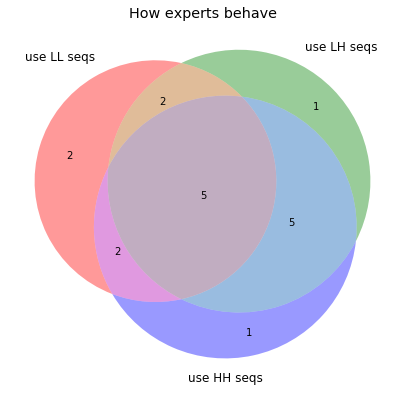

In [23]:
from matplotlib_venn import venn3, venn3_circles
plt.figure(figsize=(7,7))

c1= len(unique_student_list_HH_LL - (unique_student_list_HH_LH | unique_student_list_HH_HH))
c2= len(unique_student_list_HH_LH - (unique_student_list_HH_LL | unique_student_list_HH_HH))
c3= len(unique_student_list_HH_LH & unique_student_list_HH_LL - unique_student_list_HH_HH)
c4= len(unique_student_list_HH_HH - (unique_student_list_HH_LL | unique_student_list_HH_LH))
c5= len(unique_student_list_HH_LL & unique_student_list_HH_HH - unique_student_list_HH_LH)
c6= len(unique_student_list_HH_LH & unique_student_list_HH_HH - unique_student_list_HH_LL)
c7= len(unique_student_list_HH_HH & unique_student_list_HH_LH & unique_student_list_HH_LL)
v = venn3(subsets=(c1, c2, c3, c4, c5, c6, c7), set_labels = ('use LL seqs', 'use LH seqs','use HH seqs'))
# v.get_patch_by_id('100').set_alpha(1.0)
# v.get_patch_by_id('100').set_color('white')
# v.get_label_by_id('100').set_text('Unknown')
# v.get_label_by_id('A').set_text('Set "A"')
# c = venn3_circles(subsets=(1, 1, 1, 1, 1, 1, 1), linestyle='dashed')
# c[0].set_lw(1.0)
# c[0].set_ls('dotted')
plt.title("How experts behave")
# plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
#              ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()